# NGC 346 infrared profiles

Broad slit profiles across the bow shock

In [94]:
from pathlib import Path
import numpy as np
from mpdaf.obj import Image
from matplotlib import pyplot as plt
import seaborn as sns
import regions
import cmasher as cmr
sns.set_context("talk")
sns.set_color_codes()

In [8]:
irfiles = Path("../data").glob("ngc346-ir-*.fits")
irfiles = sorted(irfiles)
irfiles

[PosixPath('../data/ngc346-ir-0036-IRAC1.fits'),
 PosixPath('../data/ngc346-ir-0045-IRAC2.fits'),
 PosixPath('../data/ngc346-ir-0057-IRAC3.fits'),
 PosixPath('../data/ngc346-ir-0080-IRAC4.fits'),
 PosixPath('../data/ngc346-ir-0082-MSX-A.fits'),
 PosixPath('../data/ngc346-ir-0120-WISE3.fits'),
 PosixPath('../data/ngc346-ir-0121-MSX-C.fits'),
 PosixPath('../data/ngc346-ir-0146-MSX-D.fits'),
 PosixPath('../data/ngc346-ir-0214-MSX-E.fits'),
 PosixPath('../data/ngc346-ir-0221-WISE4.fits'),
 PosixPath('../data/ngc346-ir-0236-MIPS1.fits'),
 PosixPath('../data/ngc346-ir-0714-MIPS2.fits'),
 PosixPath('../data/ngc346-ir-1000-PACS-B.fits'),
 PosixPath('../data/ngc346-ir-1600-PACS-R.fits'),
 PosixPath('../data/ngc346-ir-2500-SPIRE250.fits'),
 PosixPath('../data/ngc346-ir-3500-SPIRE350.fits'),
 PosixPath('../data/ngc346-ir-5000-SPIRE500.fits')]

In [114]:
class IRim:
    def __init__(self, path):
        self.path = path
        self.im = Image(str(self.path))
        s = str(path).replace("../data/ngc346-ir-", "").replace(".fits", "")
        self.wav = np.round(0.1 * float(s[:4]), 1)
        self.label = s[5:]
        self.profile = self.im.data[710:790, :].mean(axis=0)
        nx = len(profile)
        self.pos = 0.2 * (np.arange(nx) - nx/2)
        self.bg = (self.profile[:50].mean() + self.profile[-50:].mean()) / 2
        self.profile -= self.bg
        self.im.data -= self.bg


        
    def __repr__(self):
        return f"IRim({self.label}, {self.wav})"


In [115]:
irdata = {}
for path in sorted(irfiles):
    irim = IRim(path)
    irdata[irim.label] = irim
irdata

{'IRAC1': IRim(IRAC1, 3.6),
 'IRAC2': IRim(IRAC2, 4.5),
 'IRAC3': IRim(IRAC3, 5.7),
 'IRAC4': IRim(IRAC4, 8.0),
 'MSX-A': IRim(MSX-A, 8.2),
 'WISE3': IRim(WISE3, 12.0),
 'MSX-C': IRim(MSX-C, 12.1),
 'MSX-D': IRim(MSX-D, 14.6),
 'MSX-E': IRim(MSX-E, 21.4),
 'WISE4': IRim(WISE4, 22.1),
 'MIPS1': IRim(MIPS1, 23.6),
 'MIPS2': IRim(MIPS2, 71.4),
 'PACS-B': IRim(PACS-B, 100.0),
 'PACS-R': IRim(PACS-R, 160.0),
 'SPIRE250': IRim(SPIRE250, 250.0),
 'SPIRE350': IRim(SPIRE350, 350.0),
 'SPIRE500': IRim(SPIRE500, 500.0)}

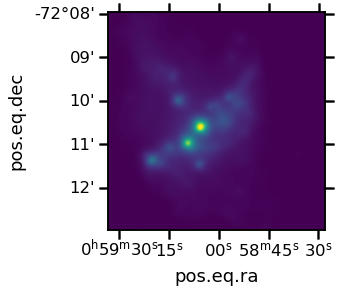

In [116]:
irdata["WISE3"].im.plot(vmin=0.0, vmax=35.0, use_wcs=True)

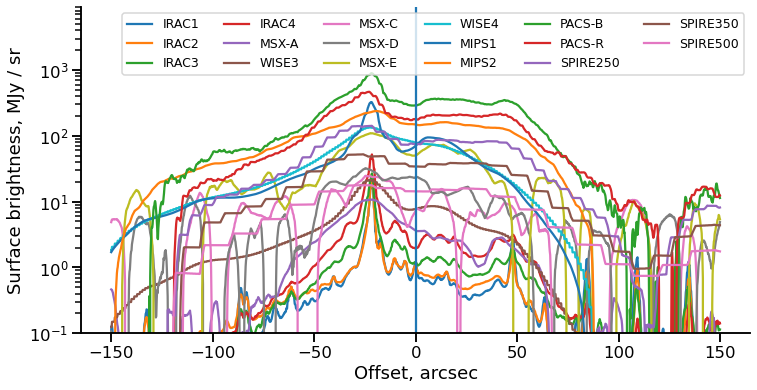

In [117]:
fig, ax = plt.subplots(figsize=(12, 6))
for irim in irdata.values():
    ax.plot(irim.pos, irim.profile, label=irim.label)
ax.legend(ncol=6, fontsize="x-small")
ax.axvline(0.0)
ax.set(
    xlabel="Offset, arcsec",
    ylabel="Surface brightness, MJy / sr",
    yscale="log",
    ylim=[0.1, 9000],
)
sns.despine();

In [111]:
goodbands = "WISE3", "MSX-E", "MSX-C", "WISE4", "MIPS1"

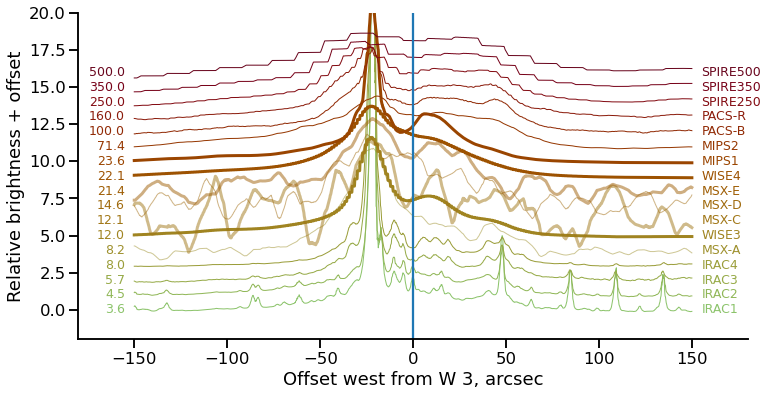

In [121]:
fig, ax = plt.subplots(figsize=(12, 6))
# Take N colors from named colormap in [0.15, 0.85] range in HEX
colors = cmr.take_cmap_colors(
    'cmr.apple_r', 
    len(irdata), 
    cmap_range=(0.25, 0.75), 
    return_fmt='hex'
)
offset = 0.0
for irim, color in zip(irdata.values(), colors):
    lw = 3.0 if irim.label in goodbands else 1.0
    alpha = 0.5 if "MSX" in irim.label else 1.0
    norm = np.mean(irim.profile.data)
    ax.plot(irim.pos, offset + irim.profile / norm, color=color, lw=lw, alpha=alpha)
    ax.text(155.0, offset, irim.label, va="center", fontsize="x-small", color=color)
    ax.text(-155.0, offset, f"{irim.wav:.1f}", ha="right", va="center", fontsize="x-small", color=color)
    offset += 1.0
#ax.legend(ncol=6, fontsize="x-small")
ax.axvline(0.0)
ax.set(
    xlabel="Offset west from W 3, arcsec",
    ylabel="Relative brightness + offset",
    yscale="linear",
    ylim=[-2.0, 3.0 + offset],
    xlim=[-180, 180],
)
sns.despine()
fig.savefig("../figs/ngc346-infrared-profiles.pdf");